# Imports

In [161]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import sys
import xarray
import numpy as np
from pyproj import Proj, transform
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage.draw import polygon as skpolygon
from shapely.geometry.polygon import Polygon

sys.path.append('/isipd/projects-noreplica/p_ESA_CCI_DATA/_CCI_scripts/Bennet/')
import irrgrid2irrgrid as irr2irr

def find_nearest_pix(lons,lats,xlon,xlat):
    dist=( (lats-xlat)**2 +(lons-xlon)**2 )
    sidx=np.unravel_index(dist.argmin(),dist.shape) 
    return sidx,dist[sidx[0],sidx[1]]

def use_polygon(lons,lats,polygon):
    '''
    lons: 2d field of longitudes (e.g. from satellite swath or np.meshgrid(lon,lat))
    lats: 2d field of latitudes  (see above)
    poly: array [[lon0,lat0],[lon1,lat1],...], at least three corner points
    '''
    polg=[]
    for p in polygon:
        polg.append(find_nearest_pix(lons,lats,p[0],p[1])[0])
    
    polg=np.array(polg)
    mask = np.zeros(lons.shape, dtype=np.uint8)
    r,c = polg[:,0], polg[:,1]
    rr, cc = skpolygon(r, c)
    mask[rr, cc] = 1
    return mask.astype(bool)


# Read in two datasets with different spatial resolution

## 1) IBCAO DEM

In [92]:
xds = xarray.open_dataset(r"/isipd/projects-noreplica/p_ESA_CCI_DATA/IBCAO/rasterout.tif")
lon_var_IBCAO = np.array(xds["x"])
lat_var_IBCAO = np.array(xds["y"])
IBCAO = np.array(xds["band_data"][0])

In [ ]:
# create a subset
lon_var_IBCAO_sub = lon_var_IBCAO[2500:11000]
lat_var_IBCAO_sub = lat_var_IBCAO[1000:]
IBCAO_sub = IBCAO[1000:,2500:11000]

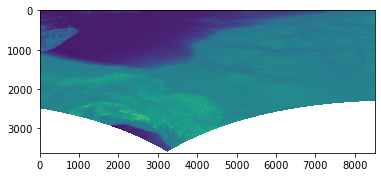

In [181]:
plt.imshow(IBCAO_sub)

# SNOW CCI SWE

In [85]:
INFILE_Path = "/isipd/projects-noreplica/p_ESA_CCI_DATA/snow_cover_cci/SWE/2012/12/20121219-ESACCI-L3C_SNOW-SWE-SSMIS-DMSP-fv1.0.nc"
nc_data = nc.Dataset(INFILE_Path)
nc_time_var = nc_data.variables['time']
#print(nc_data.variables)
cal = nc_time_var.getncattr('calendar')
date_units = nc_time_var.getncattr('units')
dtime = nc.num2date(nc_time_var[:],date_units,calendar=cal, only_use_cftime_datetimes=False)
SWE = nc_data.variables['swe'][0]
lat_var_CCISNOW = nc_data.variables['lat']
lon_var_CCISNOW = nc_data.variables['lon']

{'time': <class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    axis: T
    standard_name: time
    long_name: time
    units: hours since 1950-01-01 00:00:00
    calendar: standard
unlimited dimensions: time
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 lat_bnds(lat, nv)
unlimited dimensions: 
current shape = (720, 2)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 lon_bnds(lon, nv)
unlimited dimensions: 
current shape = (1440, 2)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    long_name: WGS84 latitude coordinates, center of pixel
    units: degree_north
    standard_name: latitude
    axis: Y
    bounds: lat_bnds
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4.

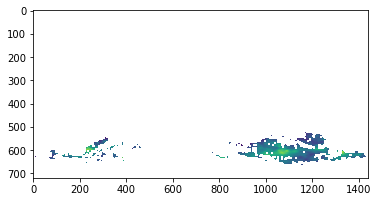

In [180]:
plt.imshow(SWE)

# Meshgrid both grids

In [137]:
xx_IBCARO, yy_IBCAO = np.meshgrid(lon_var_IBCAO, lat_var_IBCAO)
xx_SWE, yy_SWE = np.meshgrid(lon_var_CCISNOW, lat_var_CCISNOW)

# Resample data onto SWE grid

In [138]:
SWE_master={'lon':xx_SWE,'lat':yy_SWE,'SWE':SWE}
IBCAO_slave={'lon':xx_IBCARO,'lat':yy_IBCAO,'Bathy':IBCAO}

Resampled = irr2irr.slave2master_2(SWE_master['lon'], SWE_master['lat'], IBCAO_slave['lon'], IBCAO_slave['lat'], IBCAO_slave)

/isipd/projects/p_ESACCIARCTICOM/_script/ONESIMUS/irrgrid2irrgrid.py:127: RuntimeWarning: invalid value encountered in true_divide
  av=np.bincount(self.slave_idx,self.field.flat[:])/np.bincount(self.slave_idx)
/isipd/projects/p_ESACCIARCTICOM/_script/ONESIMUS/irrgrid2irrgrid.py:144: RuntimeWarning: invalid value encountered in true_divide
  out = np.bincount(self.slave_idx,field.flat[:])/np.bincount(self.slave_idx)


# Plot both resampled datasets

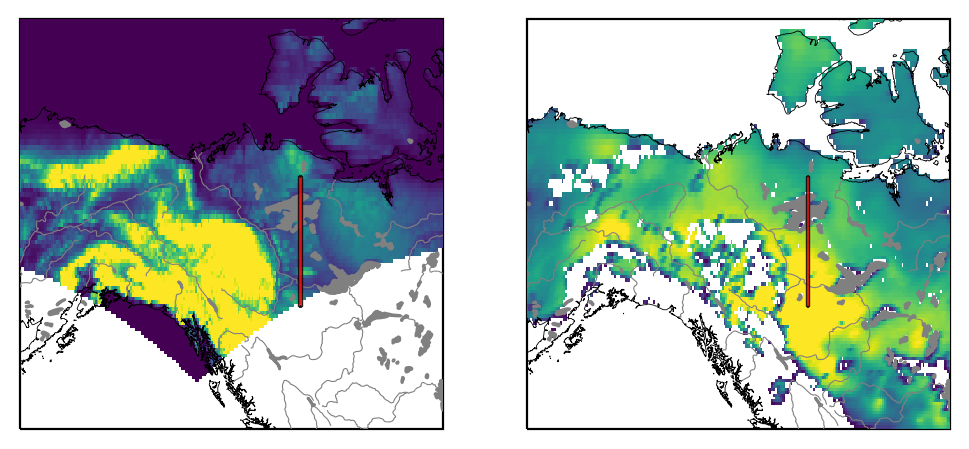

In [173]:
fig1 = plt.figure(figsize=(6, 9),tight_layout=True, dpi=200)
fig1.patch.set_facecolor('w')

gs = fig1.add_gridspec(1, 2)

ax1 = fig1.add_subplot(gs[0, 0], projection=ccrs.Mercator(central_longitude=0.0))
ax2 = fig1.add_subplot(gs[0, 1], projection=ccrs.Mercator(central_longitude=0.0))

ax1.set_extent([-160, -100, 50, 75], crs=ccrs.PlateCarree())
ax2.set_extent([-160, -100, 50, 75], crs=ccrs.PlateCarree())

f1 = ax1.pcolormesh(xx_SWE, yy_SWE, Resampled["Bathy"], shading='flat', 
                    cmap=plt.cm.viridis, zorder=11, transform = ccrs.PlateCarree(),
                    vmin=0, vmax=1000)

f2 = ax2.pcolormesh(xx_SWE, yy_SWE, SWE, shading='flat', 
                    cmap=plt.cm.viridis, zorder=11, transform = ccrs.PlateCarree(),
                    vmin=0, vmax=100)

ax1.coastlines(resolution='10m', color='black', linewidth=0.3, zorder=11)
ax1.add_feature(cartopy.feature.RIVERS, linewidth=0.4, color="grey", zorder=11)
ax1.add_feature(cfeature.LAKES, facecolor="grey", zorder=11)

ax2.coastlines(resolution='10m', color='black', linewidth=0.3, zorder=11)
ax2.add_feature(cartopy.feature.RIVERS, linewidth=0.4, color="grey", zorder=11)
ax2.add_feature(cfeature.LAKES, facecolor="grey", zorder=11)

#Define coordinates for extraction polygon
MinLat, MinLon, MaxLat, MaxLon  = 60, -120.5, 68, -120.0

pgon = Polygon(((MinLon, MinLat),
                (MinLon, MaxLat),
                (MaxLon, MaxLat),
                (MaxLon, MinLat),
                (MinLon, MinLat)))

ax1.add_geometries([pgon], crs=ccrs.PlateCarree(), facecolor='r',lw=0.5, edgecolor='k', alpha=0.8, zorder=11)
ax2.add_geometries([pgon], crs=ccrs.PlateCarree(), facecolor='r', lw=0.5, edgecolor='k', alpha=0.8, zorder=11)

plt.show()

# Extract pixels in a given polygon

In [158]:
Polygon = [(MinLon,MaxLat), (MinLon,MinLat),(MaxLon,MinLat),(MaxLon,MaxLat)]
Mask_Polygon = use_polygon(xx_SWE, yy_SWE, Polygon)

Text(0.5, 0, 'IBCAO Bathy')

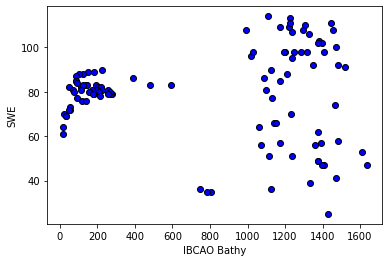

In [179]:
plt.scatter(Resampled["Bathy"][Mask_Polygon], SWE[Mask_Polygon], marker="o", edgecolor="k", facecolor="b")
plt.ylabel("SWE")
plt.xlabel("IBCAO Bathy")